In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging

logging.getLogger('jieba').setLevel(logging.WARN)
logging.getLogger('fgclassifier').setLevel(logging.INFO)

In [2]:
import os

os.chdir('..')

# Model Selection

## Baseline Models

This notebook shows how to use our baseline model.
It also demonstrates how to test different feature models (i.e.,
different ways of building the features) at the same time.

We will use mostly the Google Translated English dataset for this
demonstration purpose.

In [3]:
import config
from collections import defaultdict
from sklearn.model_selection import train_test_split

from fgclassifier.utils import read_data, get_dataset

X_train, y_train = read_data(get_dataset('train'))
X_test, y_test = read_data(get_dataset('valid'))

2018-12-03 22:00:39,243 [INFO] Reading /opt/storage/train/sentiment_analysis_trainingset.csv.tokenized.csv..
2018-12-03 22:00:41,797 [INFO] Reading /opt/storage/train/sentiment_analysis_trainingset.csv..
2018-12-03 22:00:44,693 [INFO] Reading /opt/storage/valid/sentiment_analysis_validationset.csv.tokenized.csv..
2018-12-03 22:00:45,058 [INFO] Reading /opt/storage/valid/sentiment_analysis_validationset.csv..
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Traceback (most recent call last):
  File "/Users/jesse/anaconda3/envs/idp/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/jesse/anaconda3/envs/idp/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
Traceback (most recent call last):
  File "/Users/jesse/anaconda3/envs/idp/lib/python3.6/multiprocessing/pool.py", line 108, in w

In [4]:
# Cache feature models and trained fetures, we make this cache object
# so different steps can reuse previously transformed features
fm = defaultdict(dict)

In [14]:
# del fm['tfidf_sv']
# del fm['tfidf_sv_dense']
# del fm['lsa_200_sv']
# del fm['lsa_500_sv']

In [5]:
from fgclassifier.features import FeaturePipeline, logger

for name in [
    'word2vec', 'word2vec_minmax',
    'count', 'tfidf', 'lsa_500', 'lsa_1k',
    'count_sv', 'tfidf_sv', 'tfidf_sv_dense',
    'lsa_500_sv',
]:
    logger.info(f'Building features for {name}...')
    model = FeaturePipeline.from_spec(name, cache=fm)
    model.fit_transform(X_train)
    model.transform(X_test)

2018-12-03 22:05:15,525 [INFO] 'pattern' package not found; tag filters are not available for English
2018-12-03 22:05:15,540 [INFO] Building features for word2vec...
2018-12-03 22:05:29,174 [INFO] collecting all words and their counts
2018-12-03 22:05:29,175 [INFO] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-12-03 22:05:30,000 [INFO] PROGRESS: at sentence #10000, processed 1933558 words, keeping 66880 word types
2018-12-03 22:05:30,588 [INFO] PROGRESS: at sentence #20000, processed 3856795 words, keeping 95599 word types
2018-12-03 22:05:31,015 [INFO] PROGRESS: at sentence #30000, processed 5773014 words, keeping 117449 word types
2018-12-03 22:05:31,533 [INFO] PROGRESS: at sentence #40000, processed 7702524 words, keeping 136043 word types
2018-12-03 22:05:32,019 [INFO] PROGRESS: at sentence #50000, processed 9620709 words, keeping 152756 word types
2018-12-03 22:05:32,732 [INFO] PROGRESS: at sentence #60000, processed 11539385 words, keeping 168092 word ty

2018-12-03 22:06:32,442 [INFO] EPOCH 2 - PROGRESS: at 7.13% examples, 379077 words/s, in_qsize 6, out_qsize 1
2018-12-03 22:06:33,475 [INFO] EPOCH 2 - PROGRESS: at 9.29% examples, 369851 words/s, in_qsize 4, out_qsize 1
2018-12-03 22:06:34,577 [INFO] EPOCH 2 - PROGRESS: at 11.56% examples, 361292 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:06:35,628 [INFO] EPOCH 2 - PROGRESS: at 13.23% examples, 343385 words/s, in_qsize 6, out_qsize 0
2018-12-03 22:06:36,641 [INFO] EPOCH 2 - PROGRESS: at 14.89% examples, 332220 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:06:37,647 [INFO] EPOCH 2 - PROGRESS: at 16.67% examples, 326069 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:06:38,669 [INFO] EPOCH 2 - PROGRESS: at 18.22% examples, 317372 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:06:39,688 [INFO] EPOCH 2 - PROGRESS: at 20.16% examples, 316547 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:06:40,700 [INFO] EPOCH 2 - PROGRESS: at 22.81% examples, 325806 words/s, in_qsize 5, out_qsize 0
201

2018-12-03 22:07:45,760 [INFO] EPOCH 3 - PROGRESS: at 62.84% examples, 285577 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:07:46,762 [INFO] EPOCH 3 - PROGRESS: at 64.50% examples, 285063 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:07:47,771 [INFO] EPOCH 3 - PROGRESS: at 66.58% examples, 286230 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:07:48,778 [INFO] EPOCH 3 - PROGRESS: at 68.63% examples, 287296 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:07:49,782 [INFO] EPOCH 3 - PROGRESS: at 70.55% examples, 287777 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:07:50,832 [INFO] EPOCH 3 - PROGRESS: at 72.66% examples, 288683 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:07:51,893 [INFO] EPOCH 3 - PROGRESS: at 74.55% examples, 288693 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:07:52,924 [INFO] EPOCH 3 - PROGRESS: at 76.46% examples, 288890 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:07:53,947 [INFO] EPOCH 3 - PROGRESS: at 78.55% examples, 289728 words/s, in_qsize 5, out_qsize 0
2

2018-12-03 22:08:59,673 [INFO] EPOCH 4 - PROGRESS: at 89.69% examples, 263546 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:09:00,689 [INFO] EPOCH 4 - PROGRESS: at 91.16% examples, 262980 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:09:01,734 [INFO] EPOCH 4 - PROGRESS: at 92.55% examples, 262025 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:09:02,803 [INFO] EPOCH 4 - PROGRESS: at 94.00% examples, 261264 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:09:03,844 [INFO] EPOCH 4 - PROGRESS: at 96.00% examples, 262000 words/s, in_qsize 6, out_qsize 0
2018-12-03 22:09:04,845 [INFO] EPOCH 4 - PROGRESS: at 97.32% examples, 261051 words/s, in_qsize 5, out_qsize 2
2018-12-03 22:09:05,983 [INFO] EPOCH 4 - PROGRESS: at 98.71% examples, 259909 words/s, in_qsize 4, out_qsize 1
2018-12-03 22:09:06,581 [INFO] worker thread finished; awaiting finish of 2 more threads
2018-12-03 22:09:06,588 [INFO] worker thread finished; awaiting finish of 1 more threads
2018-12-03 22:09:06,593 [INFO] worker thread 

2018-12-03 22:10:09,854 [INFO] EPOCH 6 - PROGRESS: at 27.50% examples, 205177 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:10:10,867 [INFO] EPOCH 6 - PROGRESS: at 28.50% examples, 202962 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:10:11,874 [INFO] EPOCH 6 - PROGRESS: at 29.86% examples, 203645 words/s, in_qsize 4, out_qsize 1
2018-12-03 22:10:12,927 [INFO] EPOCH 6 - PROGRESS: at 31.38% examples, 205157 words/s, in_qsize 6, out_qsize 0
2018-12-03 22:10:13,937 [INFO] EPOCH 6 - PROGRESS: at 32.67% examples, 205057 words/s, in_qsize 6, out_qsize 0
2018-12-03 22:10:14,940 [INFO] EPOCH 6 - PROGRESS: at 33.77% examples, 204090 words/s, in_qsize 6, out_qsize 1
2018-12-03 22:10:15,945 [INFO] EPOCH 6 - PROGRESS: at 35.15% examples, 204635 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:10:17,008 [INFO] EPOCH 6 - PROGRESS: at 35.60% examples, 199549 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:10:18,019 [INFO] EPOCH 6 - PROGRESS: at 36.53% examples, 197818 words/s, in_qsize 5, out_qsize 0
2

2018-12-03 22:11:24,838 [INFO] EPOCH 7 - PROGRESS: at 30.92% examples, 268202 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:11:25,867 [INFO] EPOCH 7 - PROGRESS: at 32.81% examples, 269789 words/s, in_qsize 6, out_qsize 0
2018-12-03 22:11:26,896 [INFO] EPOCH 7 - PROGRESS: at 34.95% examples, 273065 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:11:27,914 [INFO] EPOCH 7 - PROGRESS: at 36.88% examples, 274422 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:11:28,962 [INFO] EPOCH 7 - PROGRESS: at 38.51% examples, 273228 words/s, in_qsize 6, out_qsize 0
2018-12-03 22:11:29,965 [INFO] EPOCH 7 - PROGRESS: at 39.92% examples, 271284 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:11:30,967 [INFO] EPOCH 7 - PROGRESS: at 41.84% examples, 273024 words/s, in_qsize 4, out_qsize 1
2018-12-03 22:11:31,993 [INFO] EPOCH 7 - PROGRESS: at 43.67% examples, 273487 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:11:33,026 [INFO] EPOCH 7 - PROGRESS: at 45.73% examples, 274994 words/s, in_qsize 5, out_qsize 0
2

2018-12-03 22:12:38,085 [INFO] EPOCH 8 - PROGRESS: at 69.14% examples, 293630 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:12:39,138 [INFO] EPOCH 8 - PROGRESS: at 71.03% examples, 293587 words/s, in_qsize 4, out_qsize 1
2018-12-03 22:12:40,174 [INFO] EPOCH 8 - PROGRESS: at 73.10% examples, 294244 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:12:41,259 [INFO] EPOCH 8 - PROGRESS: at 74.55% examples, 292218 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:12:42,273 [INFO] EPOCH 8 - PROGRESS: at 76.46% examples, 292457 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:12:43,277 [INFO] EPOCH 8 - PROGRESS: at 78.16% examples, 291873 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:12:44,320 [INFO] EPOCH 8 - PROGRESS: at 79.94% examples, 291423 words/s, in_qsize 3, out_qsize 2
2018-12-03 22:12:45,363 [INFO] EPOCH 8 - PROGRESS: at 81.87% examples, 291485 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:12:46,384 [INFO] EPOCH 8 - PROGRESS: at 84.02% examples, 292574 words/s, in_qsize 5, out_qsize 0
2

2018-12-03 22:13:52,074 [INFO] EPOCH 9 - PROGRESS: at 90.66% examples, 257466 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:13:53,085 [INFO] EPOCH 9 - PROGRESS: at 91.92% examples, 256508 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:13:54,090 [INFO] EPOCH 9 - PROGRESS: at 93.31% examples, 256002 words/s, in_qsize 4, out_qsize 1
2018-12-03 22:13:55,152 [INFO] EPOCH 9 - PROGRESS: at 94.64% examples, 255014 words/s, in_qsize 6, out_qsize 2
2018-12-03 22:13:56,165 [INFO] EPOCH 9 - PROGRESS: at 96.05% examples, 254392 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:13:57,301 [INFO] EPOCH 9 - PROGRESS: at 97.07% examples, 252274 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:13:58,338 [INFO] EPOCH 9 - PROGRESS: at 98.08% examples, 250738 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:13:59,364 [INFO] EPOCH 9 - PROGRESS: at 99.54% examples, 250403 words/s, in_qsize 5, out_qsize 0
2018-12-03 22:13:59,563 [INFO] worker thread finished; awaiting finish of 2 more threads
2018-12-03 22:13:59,574

KeyboardInterrupt: 

Exam the quality of the top terms:

In [22]:
from collections import Counter

print('Data Shape:', X_train.shape, X_test.shape)

for mn in ['count', 'count_sv']:
    model = fm[mn]['model'].named_steps[mn]
    x_train = fm[mn]['train']
    counts = np.sum(x_train, axis=0).flat
    counts = {k: counts[v] for k, v in model.vocabulary_.items()}
    print('\nmin_df: %.3f, max_df: %.3f, ngram_range: %s' % (
        model.min_df, model.max_df, model.ngram_range
    ))
    print('\nvocab size: %s\n' % len(model.vocabulary_))
    print('\n'.join([
        '%s \t %s' % (k, v)
        for k, v in Counter(counts).most_common()[:10]]))

Data Shape: (105000,) (15000,)

min_df: 0.005, max_df: 0.990, ngram_range: (1, 5)

vocab size: 2959

味道 	 124409
不错 	 120832
感觉 	 91453
可以 	 90883
好吃 	 83884
还是 	 83418
没有 	 75014
比较 	 73069
我们 	 67480
就是 	 66943

min_df: 0.010, max_df: 0.990, ngram_range: (1, 5)

vocab size: 1486

味道 	 124409
不错 	 120832
感觉 	 91453
可以 	 90883
好吃 	 83884
还是 	 83418
没有 	 75014
比较 	 73069
我们 	 67480
就是 	 66943


In [24]:
fm['tfidf']['model'].named_steps

{'count': FeaturePipeline(steps=count),
 'tfidf': Tfidf(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)}

## The Very Basic TF-IDF + LDA classifier

In [25]:
# Impact all feature models at once, so to avoid
# classes being reloaded and causing save_model to fail
from fgclassifier.baseline import Baseline, Dummy
from fgclassifier.classifiers import LDA
from fgclassifier.train import fm_cross_check

In [26]:
# Linear Discriminant Analysis, specify the FeaturePipeline
# as steps
model = Baseline(('LDA', LDA), fm=fm['lsa_200']['model'])

# Always pass in the original features
# the pipeline will take care of the cache
model.fit(X_train, y_train)
print(model.name)
print('Final score:', model.score(X_test, y_test))

2018-12-03 16:35:40,836 [INFO]   lsa_200: fit_transform use cache.
2018-12-03 16:38:10,370 [INFO]   lsa_200: transform use cache.


lsa_200_LDA


2018-12-03 16:38:10,648 [INFO] [Validate]: F1 Scores
2018-12-03 16:38:10,664 [INFO]   location_traffic_convenience            	0.4216
/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-03 16:38:10,674 [INFO]   location_distance_from_business_district	0.3212
2018-12-03 16:38:10,680 [INFO]   location_easy_to_find                   	0.3737
2018-12-03 16:38:10,685 [INFO]   service_wait_time                       	0.4443
2018-12-03 16:38:10,693 [INFO]   service_waiters_attitude                	0.5768
2018-12-03 16:38:10,698 [INFO]   service_parking_convenience             	0.4081
2018-12-03 16:38:10,703 [INFO]   service_serving_speed                   	0.4231
2018-12-03 16:38:10,708 [INFO]   price_level                             	0.4622
2018-12-03 16:38:10,713 [INFO]   price_cost_eff

Final score: 0.43588017714066274


In [27]:
model.scores(X_test, y_test)

2018-12-03 16:38:10,907 [INFO]   lsa_200: transform use cache.
2018-12-03 16:38:11,154 [INFO] [Validate]: F1 Scores
2018-12-03 16:38:11,160 [INFO]   location_traffic_convenience            	0.4216
/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-03 16:38:11,166 [INFO]   location_distance_from_business_district	0.3212
2018-12-03 16:38:11,171 [INFO]   location_easy_to_find                   	0.3737
2018-12-03 16:38:11,176 [INFO]   service_wait_time                       	0.4443
2018-12-03 16:38:11,183 [INFO]   service_waiters_attitude                	0.5768
2018-12-03 16:38:11,188 [INFO]   service_parking_convenience             	0.4081
2018-12-03 16:38:11,194 [INFO]   service_serving_speed                   	0.4231
2018-12-03 16:38:11,200 [INFO]   price_level                     

[0.4216034504833237,
 0.32121982251231634,
 0.3736779422878393,
 0.44433567028770693,
 0.5767993817019281,
 0.4080903682809518,
 0.4230675551515519,
 0.4622230622791564,
 0.4542291267911739,
 0.525597439225672,
 0.43450171068241394,
 0.4133843136767832,
 0.3996748693028679,
 0.4768842811889512,
 0.36269423722351524,
 0.5286573221305858,
 0.3335855129187495,
 0.38940573775982806,
 0.4841382505503321,
 0.4838334883776081]

## Search for the Best Feature + Classifier Combination

In [28]:
# Run for all classifiers and feature builders
all_avg_scores, all_scores = defaultdict(dict), defaultdict(dict)

In [29]:
from fgclassifier import classifiers
from fgclassifier.baseline import Dummy

Dummy(classifiers.DummyStratified)

Dummy(classifier=None)

In [ ]:
conf = {
    'fm_cache': fm,
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'results': {
        'models': {},
        'avg': all_avg_scores,
        'all': all_scores
    }
}

In [30]:
from IPython.display import clear_output

# We'd only need to run the dummy models on one feature model,
# as they do not care about the features
fm_cross_check(
    ['tfidf_sv'],
    ['DummyStratified', 'DummyMostFrequent'],
    model_cls=Dummy, **conf)

# Naive Bayes models cannot handle negative values, so we pass
# in only tfidf features
fm_cross_check(
    ['tfidf', 'tfidf_sv'],
    ['MultinomialNB', 'ComplementNB'], **conf)

# All other models can run on many classifiers
results = fm_cross_check(
    ['lsa_200',
     'lsa_500',
     'lsa_1k',
     'tfidf_sv_dense',
     'lsa_200_sv',
     'lsa_500_sv',
    ],
    ['LDA', 'LinearSVC', 'Logistic', 'Ridge'], **conf)

clear_output()

In [31]:
rows = {}
for fm_name in all_scores:
    for clf_name in all_scores[fm_name]:
        key = f'{fm_name}.{clf_name}'
        rows[key] = [all_avg_scores[fm_name][clf_name],
                     *all_scores[fm_name][clf_name]]
df = pd.DataFrame(rows)
df.index = ['average', *y_train.columns]
df = df.T.sort_values('average', ascending=False)
df

2018-12-03 21:50:16,304 [INFO] 'pattern' package not found; tag filters are not available for English


,average,location_traffic_convenience,location_distance_from_business_district,location_easy_to_find,service_wait_time,service_waiters_attitude,service_parking_convenience,service_serving_speed,price_level,price_cost_effective,...,environment_decoration,environment_noise,environment_space,environment_cleaness,dish_portion,dish_taste,dish_look,dish_recommendation,others_overall_experience,others_willing_to_consume_again
tfidf_sv_dense.LDA,0.513829,0.497179,0.374741,0.514774,0.515326,0.618827,0.568878,0.500501,0.538489,0.536242,...,0.539533,0.522035,0.540324,0.570281,0.475333,0.548868,0.425173,0.422477,0.496759,0.514602
lsa_1k.LDA,0.505289,0.454485,0.366906,0.509409,0.506245,0.619549,0.535946,0.485689,0.546076,0.541355,...,0.534720,0.527362,0.505256,0.554632,0.453214,0.549955,0.417164,0.419387,0.505172,0.512305
tfidf_sv_dense.Logistic,0.491706,0.449642,0.353132,0.479612,0.455474,0.634026,0.509128,0.478900,0.553849,0.504027,...,0.527322,0.488554,0.514851,0.548850,0.459046,0.579897,0.389808,0.370579,0.499813,0.505195
lsa_1k.Logistic,0.482351,0.444467,0.353227,0.465131,0.459907,0.635039,0.462918,0.468591,0.557150,0.503026,...,0.502396,0.475771,0.479074,0.536282,0.444143,0.574186,0.373974,0.369477,0.507274,0.502314
lsa_500.LDA,0.480754,0.435804,0.345309,0.477131,0.494871,0.604645,0.506905,0.465038,0.515197,0.522944,...,0.492745,0.470935,0.461195,0.528827,0.419031,0.547501,0.368412,0.407818,0.494878,0.510679
lsa_500_sv.LDA,0.476375,0.441752,0.346489,0.475043,0.501983,0.596452,0.508239,0.457923,0.506596,0.510155,...,0.478786,0.470737,0.457825,0.526694,0.414436,0.538940,0.367399,0.399205,0.488968,0.500169
tfidf_sv_dense.LinearSVC,0.464256,0.453178,0.354283,0.448063,0.421555,0.601225,0.470959,0.449711,0.537817,0.459530,...,0.485655,0.470750,0.497616,0.517269,0.417235,0.536899,0.345997,0.336255,0.491537,0.484863
lsa_500.Logistic,0.457748,0.432548,0.342524,0.447242,0.449079,0.619056,0.440584,0.454857,0.522981,0.480391,...,0.458069,0.420949,0.432338,0.483742,0.405041,0.565496,0.331152,0.355285,0.498266,0.496282
lsa_500_sv.Logistic,0.456213,0.433683,0.345426,0.447918,0.436750,0.610120,0.452326,0.453743,0.512654,0.469194,...,0.453193,0.425859,0.426479,0.492220,0.403034,0.569555,0.334877,0.351554,0.491498,0.495246
lsa_1k.LinearSVC,0.451432,0.444010,0.353715,0.436934,0.415363,0.596639,0.406974,0.431430,0.543330,0.463854,...,0.467554,0.450886,0.442410,0.486652,0.406807,0.533525,0.340069,0.330709,0.494488,0.475527


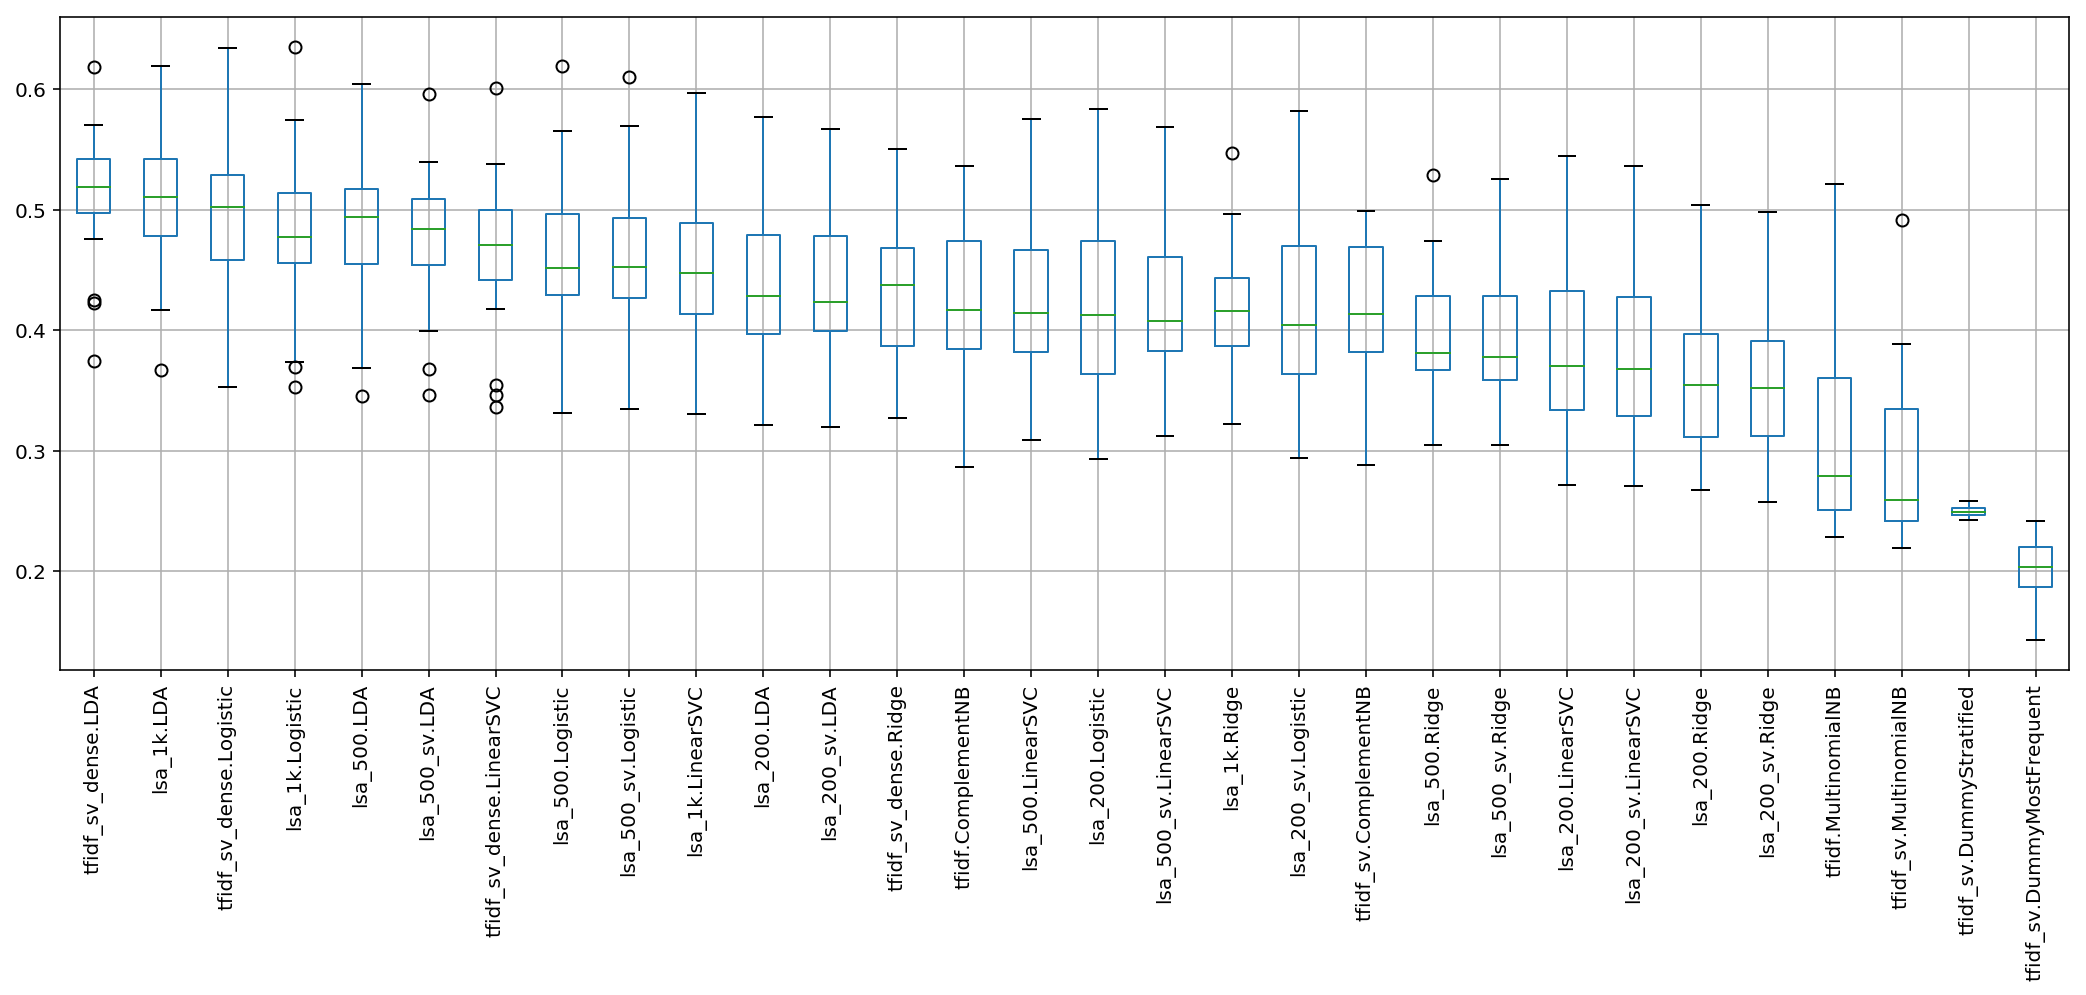

In [32]:
import matplotlib.pyplot as plt

df.T.drop(['average']).boxplot(
    figsize=(18, 6), rot=90)

plt.show()

Let's save the models for future use.

In [33]:
from fgclassifier.utils import save_model

def clear_cache(model):
    if hasattr(model, 'steps'):
        for (name, step) in model.steps:
            clear_cache(step)
    if hasattr(model, 'cache'):
        model.cache = None
    return model

for name, model in results['models'].items():
    clear_cache(model)
    save_model(model)

2018-12-03 21:50:19,833 [INFO] Saving model to /opt/storage/models/dummy_transform_DummyStratified.pkl...


PicklingError: Can't pickle <class 'fgclassifier.features.DummyTransform'>: it's not the same object as fgclassifier.features.DummyTransform

## Conclusion

- `ComplementNB` performs much better than a simple MultinomialNB, because our class labels are mostly unbalanced.
- `LatentDirichletAllocation` topics as features are not suitable for our classification problem, as features are often collinear. They often fare no better than the dummy classifier where we simply return the most frequent labels.
- LSA (Latent Semantic Analysis, Tfidf + SVD) shows a much more promising outlook, especially when combined with Linear Discriminant Analysis or SVC.
- Find the right vocabulary (min_df and ngram range) is crucial. Throw away noises early often outperforms running dimension reduction later.
- Basically SVD makes each feature (component) more indendent with each other, making LDA and SVC easier to come up with good fittings.
- Tree based models are not particularly useful. But the results may be different had we tuned the tree structure more.

## Next Steps

Required:

- Tune hyperparamters for `ComplementNB`, `TruncatedSVD`, `LinearDiscriminantAnalysis` and `SVC`/`LinearSVC`. Try different kernel functions.
- Try over-/under-sampling since most of our classes are imbalanced. [Possible solution](https://imbalanced-learn.org/)
- Test some boosting methods, especially [xgboost](https://xgboost.readthedocs.io/en/latest/).
- Test word embedding as features.

Optional:

- Possibly use different classifier for different labels.
- Test two step predictions: first run binary prediction for "mentioned" vs "not mentioned", i.e., -2 vs (-1, 0, 1), then predict (-1, 0, 1).
    - This could happen as either [ClassifierChain](https://scikit-learn.org/stable/modules/multiclass.html#classifierchain) or separate steps.

In [25]:
model = results['models']['lsa_500_en_LDA']
print(X_test[0:1].shape)
probas = model.predict_proba(X_test[0:1])
probas[0].shape

2018-12-03 11:52:24,510 [INFO]   lsa_500_en: transform use cache.


(1,)


(2000, 4)

In [20]:
model.predict(X_test[0:1])

2018-12-03 11:28:47,421 [INFO]   lsa_500_en: transform use cache.


array([[-2, -2, -2, ..., -2,  1, -2],
       [-2, -2, -2, ..., -2,  1, -2],
       [-2, -2, -2, ..., -2,  1,  1],
       ...,
       [-2, -2, -1, ...,  1, -1, -1],
       [-2, -2, -2, ..., -2,  0, -2],
       [-2, -2, -2, ..., -2,  1, -2]])